#1. Data Upload

In [19]:
# Package installation (Google Colab)
!pip install xgboost lightgbm imbalanced-learn shap tableone

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import io
import time
from datetime import datetime
from PIL import Image
from IPython.display import display
from google.colab import files

warnings.filterwarnings('ignore')
np.random.seed(42)

# Machine learning models
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Preprocessing and model selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, roc_auc_score, f1_score, precision_score, recall_score, auc, make_scorer, average_precision_score

# Statistical analysis
from scipy.stats import mannwhitneyu, chi2_contingency, fisher_exact, ttest_rel
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tableone import TableOne

# Model interpretation
import shap


In [2]:
# Data loading
uploaded = files.upload()
df_2022 = pd.read_excel("CPE_2022.xlsx")

uploaded = files.upload()
df_2023 = pd.read_excel("CPE_2023.xlsx")

# Basic info
print(f"2022 Dataset: {df_2022.shape[0]} patients, {df_2022.shape[1]} features")
print(f"2023 Dataset: {df_2023.shape[0]} patients, {df_2023.shape[1]} features")

# CPE distribution
cpe_2022 = df_2022['CPE'].value_counts()
cpe_2023 = df_2023['CPE'].value_counts()

print(f"\nCPE Distribution:")
print(f"2022: CPE+ {cpe_2022[1]} ({cpe_2022[1]/len(df_2022):.1%}), CPE- {cpe_2022[0]}")
print(f"2023: CPE+ {cpe_2023[1]} ({cpe_2023[1]/len(df_2023):.1%}), CPE- {cpe_2023[0]}")

# Sample data
display(df_2022.head())
display(df_2023.head())

Saving CPE_2022.xlsx to CPE_2022.xlsx


Saving CPE_2023.xlsx to CPE_2023.xlsx
2022 Dataset: 1992 patients, 42 features
2023 Dataset: 2923 patients, 42 features

CPE Distribution:
2022: CPE+ 220 (11.0%), CPE- 1772
2023: CPE+ 233 (8.0%), CPE- 2690


,CPE,Sex,Age,Hospital days before ICU admission,Admission source,Previous hospitalization,Preexisting medical condition,Diabetes mellitus,Chronic renal disease,ESRD on renal replacement therapy,...,Cystostomy,Previous antibiotic,Fluoroquinolone,Cephalosporin,Carbapenem,β-lactam/β-lactamase inhibitor,Aminoglycoside,Admission to long-term care facility,VRE,Endoscopy
0,0,0,79,2,2,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,64,1,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,89,8,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,66,6,1,1,1,0,0,0,...,0,1,1,0,0,1,0,0,0,0
4,0,1,77,2,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,CPE,Sex,Age,Hospital days before ICU admission,Admission source,Previous hospitalization,Preexisting medical condition,Diabetes mellitus,Chronic renal disease,ESRD on renal replacement therapy,...,Cystostomy,Previous antibiotic,Fluoroquinolone,Cephalosporin,Carbapenem,β-lactam/β-lactamase inhibitor,Aminoglycoside,Admission to long-term care facility,VRE,Endoscopy
0,0,1,63,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,67,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,52,3,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,74,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,73,5,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#2. Exploratory Data Analysis (EDA)

## 2.1 Basic Data Overview

In [3]:
# Basic data overview
print(f"Dataset dimensions:")
print(f"2022: {df_2022.shape[0]} x {df_2022.shape[1]}")
print(f"2023: {df_2023.shape[0]} x {df_2023.shape[1]}")

# Column consistency check
columns_match = list(df_2022.columns) == list(df_2023.columns)
print(f"Columns identical: {columns_match}")

# Data types
print(f"\nData types (2022):")
for dtype, count in df_2022.dtypes.value_counts().items():
    print(f"  {dtype}: {count}")

# Identify feature types
numeric_cols = [col for col in df_2022.columns
                if col != 'CPE' and df_2022[col].dtype in ['int64', 'float64']]

binary_cols = [col for col in df_2022.columns
               if col != 'CPE' and len(df_2022[col].unique()) == 2
               and set(df_2022[col].unique()) == {0, 1}]

print(f"\nFeature types:")
print(f"Numeric features: {len(numeric_cols)}")
print(f"Binary features: {len(binary_cols)}")

# Sample distributions
if len(binary_cols) > 0:
    print(f"\nKey binary features (% positive):")
    for col in binary_cols[:5]:
        pct_2022 = (df_2022[col] == 1).mean() * 100
        pct_2023 = (df_2023[col] == 1).mean() * 100
        print(f"  {col}: 2022={pct_2022:.1f}% -> 2023={pct_2023:.1f}%")

if len(numeric_cols) > 0:
    print(f"\nNumeric feature ranges (2022):")
    for col in numeric_cols[:3]:
        print(f"  {col}: [{df_2022[col].min():.1f} - {df_2022[col].max():.1f}]")

Dataset dimensions:
2022: 1992 x 42
2023: 2923 x 42
Columns identical: True

Data types (2022):
  int64: 42

Feature types:
Numeric features: 41
Binary features: 38

Key binary features (% positive):
  Sex: 2022=42.9% -> 2023=44.1%
  Previous hospitalization: 2022=44.9% -> 2023=45.5%
  Preexisting medical condition: 2022=72.0% -> 2023=71.3%
  Diabetes mellitus: 2022=27.8% -> 2023=26.1%
  Chronic renal disease: 2022=5.0% -> 2023=5.1%

Numeric feature ranges (2022):
  Sex: [0.0 - 1.0]
  Age: [8.0 - 106.0]
  Hospital days before ICU admission: [1.0 - 73.0]


 ## 2.2 Target Variable Analysis

In [4]:
# Target variable analysis
print("CPE prevalence:")

# Calculate distributions
cpe_2022 = df_2022['CPE'].value_counts()
cpe_2023 = df_2023['CPE'].value_counts()

pct_pos_2022 = (cpe_2022[1] / len(df_2022)) * 100
pct_pos_2023 = (cpe_2023[1] / len(df_2023)) * 100

print(f"2022: {cpe_2022[1]}/{len(df_2022)} ({pct_pos_2022:.1f}%)")
print(f"2023: {cpe_2023[1]}/{len(df_2023)} ({pct_pos_2023:.1f}%)")

# Temporal trend
prevalence_change = pct_pos_2023 - pct_pos_2022
print(f"Change: {prevalence_change:+.1f} percentage points")

# Class imbalance ratios
ratio_2022 = cpe_2022[0] / cpe_2022[1]
ratio_2023 = cpe_2023[0] / cpe_2023[1]

print(f"\nClass imbalance (Negative:Positive):")
print(f"2022: {ratio_2022:.1f}:1")
print(f"2023: {ratio_2023:.1f}:1")

# Combined dataset
total_combined = len(df_2022) + len(df_2023)
cpe_pos_combined = cpe_2022[1] + cpe_2023[1]
ratio_combined = (len(df_2022) + len(df_2023) - cpe_pos_combined) / cpe_pos_combined

print(f"\nCombined dataset:")
print(f"Total: {total_combined} patients")
print(f"CPE+: {cpe_pos_combined} ({(cpe_pos_combined/total_combined)*100:.1f}%)")
print(f"Imbalance ratio: {ratio_combined:.1f}:1")

# Statistical test
from scipy.stats import chi2_contingency

contingency_table = [[cpe_2022[1], cpe_2022[0]],
                    [cpe_2023[1], cpe_2023[0]]]
chi2, p_value = chi2_contingency(contingency_table)[:2]

print(f"\nChi-square test: p={p_value:.4f}")
print(f"Prevalence difference: {'Significant' if p_value < 0.05 else 'Not significant'}")

CPE prevalence:
2022: 220/1992 (11.0%)
2023: 233/2923 (8.0%)
Change: -3.1 percentage points

Class imbalance (Negative:Positive):
2022: 8.1:1
2023: 11.5:1

Combined dataset:
Total: 4915 patients
CPE+: 453 (9.2%)
Imbalance ratio: 9.8:1

Chi-square test: p=0.0003
Prevalence difference: Significant


## 2.3 Feature Correlation Analysis

In [5]:
# Feature correlation analysis
feature_cols = [col for col in df_2022.columns if col != 'CPE']
correlation_matrix = df_2022[feature_cols].corr()

print(f"Analyzing {len(feature_cols)} features")

# High correlations between features
high_corr_pairs = []
threshold = 0.7

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            high_corr_pairs.append((feature1, feature2, corr_value))

print(f"\nHigh correlations (|r| > {threshold}): {len(high_corr_pairs)}")
for feature1, feature2, corr in high_corr_pairs[:5]:  # Show top 5
    print(f"  {feature1} <-> {feature2}: {corr:.3f}")

# Feature-target correlations
feature_target_corr = []
for feature in feature_cols:
    corr_value = df_2022[feature].corr(df_2022['CPE'])
    if not pd.isna(corr_value):
        feature_target_corr.append((feature, corr_value))

# Sort by absolute correlation
feature_target_corr.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"\nTop 10 features correlated with CPE:")
for i, (feature, corr) in enumerate(feature_target_corr[:10], 1):
    print(f"  {i:2d}. {feature}: {corr:.3f}")

# Multicollinearity check
high_corr_features = set()
for feature1, feature2, corr in high_corr_pairs:
    high_corr_features.add(feature1)
    high_corr_features.add(feature2)

if len(high_corr_features) > 0:
    print(f"\nMulticollinearity detected in {len(high_corr_features)} features")
    print("Consider removing redundant features or using regularization")

print(f"\nSummary:")
print(f"  High correlations: {len(high_corr_pairs)} pairs")
print(f"  Strongest predictor: {feature_target_corr[0][0]} (r={feature_target_corr[0][1]:.3f})")

Analyzing 41 features

High correlations (|r| > 0.7): 1
  Preexisting medical condition <-> Previous surgery within: 0.769

Top 10 features correlated with CPE:
   1. Previous antibiotic: 0.231
   2. β-lactam/β-lactamase inhibitor: 0.225
   3. Hospital days before ICU admission: 0.198
   4. Carbapenem: 0.191
   5. Central venous catheter: 0.191
   6. Fluoroquinolone: 0.186
   7. Cephalosporin: 0.181
   8. Steroid use: 0.160
   9. Nasogastric tube: 0.160
  10. Endotracheal tube: 0.134

Multicollinearity detected in 2 features
Consider removing redundant features or using regularization

Summary:
  High correlations: 1 pairs
  Strongest predictor: Previous antibiotic (r=0.231)


In [6]:
# VIF analysis for multicollinearity
vif_data = pd.DataFrame()
vif_data["Feature"] = feature_cols
vif_data["VIF"] = [variance_inflation_factor(df_2022[feature_cols].values, i)
                   for i in range(len(feature_cols))]

vif_data = vif_data.sort_values('VIF', ascending=False)

# High VIF features (>10 indicates multicollinearity)
high_vif = vif_data[vif_data['VIF'] > 10]

print(f"VIF Analysis:")
if len(high_vif) > 0:
    print(f"High VIF features (>10): {len(high_vif)}")
    for _, row in high_vif.head(10).iterrows():  # Show top 10
        print(f"  {row['Feature']}: {row['VIF']:.1f}")
else:
    print("No multicollinearity detected (all VIF < 10)")

VIF Analysis:
High VIF features (>10): 4
  Age: 17.6
  Admission source: 14.5
  Preexisting medical condition: 12.1
  Indwelling device: 10.8


In [7]:
# Automatic VIF-based feature removal
current_features = feature_cols.copy()

while True:
    # Calculate VIF for current features
    vif_data = pd.DataFrame()
    vif_data["Feature"] = current_features
    vif_data["VIF"] = [variance_inflation_factor(df_2022[current_features].values, i)
                       for i in range(len(current_features))]

    # Find highest VIF
    max_vif = vif_data['VIF'].max()

    if max_vif <= 10:
        break

    # Remove feature with highest VIF
    worst_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']
    current_features.remove(worst_feature)
    print(f"Removed: {worst_feature} (VIF: {max_vif:.1f})")

print(f"\nFinal result: {len(feature_cols)} -> {len(current_features)} features")
print(f"All remaining features have VIF < 10")

# Update clean_features for next steps
clean_features = current_features

Removed: Age (VIF: 17.6)
Removed: Preexisting medical condition (VIF: 11.9)
Removed: Indwelling device (VIF: 10.7)

Final result: 41 -> 38 features
All remaining features have VIF < 10


#3. Data Preparation

In [8]:
# Chronological data preparation
print("Chronological data preparation")

# Add year labels and combine
df_2022_labeled = df_2022.copy()
df_2023_labeled = df_2023.copy()
df_2022_labeled['Year'] = 2022
df_2023_labeled['Year'] = 2023

# Combine chronologically (2022 first, then 2023)
combined_df = pd.concat([df_2022_labeled, df_2023_labeled], ignore_index=True)

print(f"Combined dataset: {combined_df.shape}")
print(f"CPE prevalence: {(combined_df['CPE'].sum() / len(combined_df) * 100):.1f}%")

# Chronological split (80:20)
split_point = int(len(combined_df) * 0.8)
train_chrono = combined_df.iloc[:split_point]
test_chrono = combined_df.iloc[split_point:]

print(f"\nChronological split:")
print(f"Training: {len(train_chrono)} patients ({(train_chrono['CPE'].sum() / len(train_chrono) * 100):.1f}% CPE+)")
print(f"Test: {len(test_chrono)} patients ({(test_chrono['CPE'].sum() / len(test_chrono) * 100):.1f}% CPE+)")

# Remove year column for modeling
train_final = train_chrono.drop('Year', axis=1)
test_final = test_chrono.drop('Year', axis=1)

print(f"\nFinal datasets: Train {train_final.shape}, Test {test_final.shape}")

Chronological data preparation
Combined dataset: (4915, 43)
CPE prevalence: 9.2%

Chronological split:
Training: 3932 patients (9.2% CPE+)
Test: 983 patients (9.3% CPE+)

Final datasets: Train (3932, 42), Test (983, 42)


#4. Feature Engineering

In [9]:
# Feature engineering & selection
print("Feature engineering & selection")

# Prepare base data
base_features = [col for col in clean_features if col in train_final.columns]
X_train_base = train_final[base_features].copy()
y_train = train_final['CPE'].copy()

print(f"Base features: {len(base_features)}")

# Auto-detect feature groups and create risk scores
def get_feature_group(features, keywords):
    return [f for f in features if any(keyword.lower() in f.lower() for keyword in keywords)]

device_keywords = ['catheter', 'tube', 'drain', 'device']
antibiotic_keywords = ['antibiotic', 'quinolone', 'cephalosporin', 'carbapenem', 'lactam', 'aminoglycoside']
comorbidity_keywords = ['diabetes', 'renal', 'liver', 'cardiovascular', 'cancer', 'malignancy', 'disease']

device_features = get_feature_group(base_features, device_keywords)
antibiotic_features = get_feature_group(base_features, antibiotic_keywords)
comorbidity_features = get_feature_group(base_features, comorbidity_keywords)

# Create engineered features
X_train_eng = X_train_base.copy()

if len(device_features) > 0:
    X_train_eng['Device_Risk'] = X_train_base[device_features].sum(axis=1)
if len(antibiotic_features) > 0:
    X_train_eng['Antibiotic_Risk'] = X_train_base[antibiotic_features].sum(axis=1)
if len(comorbidity_features) > 0:
    X_train_eng['Comorbidity_Risk'] = X_train_base[comorbidity_features].sum(axis=1)

print(f"Risk scores created: Device({len(device_features)}), Antibiotic({len(antibiotic_features)}), Comorbidity({len(comorbidity_features)})")

# Univariate analysis for statistical selection
eligible_features = []

print("\nUnivariate analysis:")
for feature in X_train_eng.columns:
    X_single = sm.add_constant(X_train_eng[[feature]])

    try:
        model = sm.Logit(y_train, X_single).fit(disp=0)
        pvalue = model.pvalues[feature]
        or_value = np.exp(model.params[feature])

        if pvalue < 0.1:  # Statistical threshold
            eligible_features.append(feature)
            print(f"  {feature}: OR={or_value:.3f}, p={pvalue:.4f}")

    except:
        continue

print(f"\nEligible features (p<0.1): {len(eligible_features)}")

# Backward elimination if too many features
def backward_elimination(features, X, y, threshold=0.05):
    current_features = features.copy()

    while len(current_features) > 12:  # Keep under 12 for web deployment
        X_current = sm.add_constant(X[current_features])

        try:
            model = sm.Logit(y, X_current).fit(disp=0)
            pvalues = model.pvalues.drop('const')

            max_pvalue = pvalues.max()
            if max_pvalue > threshold:
                worst_feature = pvalues.idxmax()
                current_features.remove(worst_feature)
                print(f"Removed: {worst_feature} (p={max_pvalue:.4f})")
            else:
                break

        except:
            break

    return current_features

# Apply backward elimination if needed
if len(eligible_features) > 12:
    final_features = backward_elimination(eligible_features, X_train_eng, y_train)
else:
    final_features = eligible_features

print(f"\nFinal features selected: {len(final_features)}")
for i, feature in enumerate(final_features, 1):
    print(f"  {i:2d}. {feature}")

# Create final training dataset
X_train_final = X_train_eng[final_features]

# Apply same transformations to test set
X_test_base = test_final[base_features].copy()
y_test = test_final['CPE'].copy()

X_test_eng = X_test_base.copy()
if len(device_features) > 0:
    X_test_eng['Device_Risk'] = X_test_base[device_features].sum(axis=1)
if len(antibiotic_features) > 0:
    X_test_eng['Antibiotic_Risk'] = X_test_base[antibiotic_features].sum(axis=1)
if len(comorbidity_features) > 0:
    X_test_eng['Comorbidity_Risk'] = X_test_base[comorbidity_features].sum(axis=1)

X_test_final = X_test_eng[final_features]

print(f"\nFinal datasets: Train {X_train_final.shape}, Test {X_test_final.shape}")

Feature engineering & selection
Base features: 38
Risk scores created: Device(7), Antibiotic(6), Comorbidity(10)

Univariate analysis:
  Hospital days before ICU admission: OR=1.104, p=0.0000
  Previous hospitalization: OR=1.412, p=0.0026
  Diabetes mellitus: OR=1.370, p=0.0085
  Chronic renal disease: OR=1.889, p=0.0013
  ESRD on renal replacement therapy: OR=2.266, p=0.0000
  Chronic obstructive pulmonary disease: OR=6.606, p=0.0390
  Hematologic malignancy: OR=3.557, p=0.0154
  Previous surgery within: OR=1.665, p=0.0000
  Recent chemotherapy: OR=2.457, p=0.0000
  Immunosuppressant use: OR=2.169, p=0.0098
  Steroid use: OR=3.783, p=0.0000
  Central venous catheter: OR=2.696, p=0.0000
  Foley catheter: OR=1.464, p=0.0007
  Nasogastric tube: OR=2.581, p=0.0000
  Endotracheal tube: OR=2.249, p=0.0000
  Pigtail catheter: OR=3.874, p=0.0000
  Biliary drain: OR=5.529, p=0.0000
  Ostomy: OR=3.326, p=0.0114
  Previous antibiotic: OR=4.154, p=0.0000
  Fluoroquinolone: OR=4.020, p=0.0000
  Ce

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  Aminoglycoside: OR=9.381, p=0.0000
  Admission to long-term care facility: OR=3.406, p=0.0000
  VRE: OR=7.715, p=0.0000
  Endoscopy: OR=2.477, p=0.0000
  Device_Risk: OR=1.492, p=0.0000
  Antibiotic_Risk: OR=1.728, p=0.0000
  Comorbidity_Risk: OR=1.346, p=0.0000

Eligible features (p<0.1): 30
Removed: β-lactam/β-lactamase inhibitor (p=1.0000)
Removed: Recent chemotherapy (p=0.9513)
Removed: Cephalosporin (p=0.9148)
Removed: Previous antibiotic (p=0.8358)
Removed: Comorbidity_Risk (p=0.7476)
Removed: Device_Risk (p=0.7531)
Removed: Foley catheter (p=0.9684)
Removed: Hematologic malignancy (p=0.6233)
Removed: Previous surgery within (p=0.5971)
Removed: Immunosuppressant use (p=0.5322)
Removed: Chronic renal disease (p=0.5020)
Removed: Endotracheal tube (p=0.4440)
Removed: Pigtail catheter (p=0.3586)
Removed: Fluoroquinolone (p=0.3513)
Removed: Previous hospitalization (p=0.3089)
Removed: Ostomy (p=0.1895)
Removed: Diabetes mellitus (p=0.1999)
Removed: Chronic obstructive pulmonary dise

#5. Model development & evaluation


In [15]:
# Cross validation - 12 models comparison
print("Cross validation - 12 models comparison")

# CV setup
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define 12 models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss',
                            use_label_encoder=False, scale_pos_weight=9.9),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1, class_weight='balanced'),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'SVM': SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True),
    'Voting': VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')),
            ('rf', RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')),
            ('xgb', XGBClassifier(n_estimators=50, random_state=42, eval_metric='logloss',
                                 use_label_encoder=False, scale_pos_weight=9.9))
        ], voting='soft')
}

# Custom scoring functions
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

def npv_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fn) if (tn + fn) > 0 else 0

# Scoring metrics
scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': make_scorer(average_precision_score),
    'sensitivity': 'recall',
    'specificity': make_scorer(specificity_score),
    'ppv': 'precision',
    'npv': make_scorer(npv_score),
    'f1': 'f1',
    'accuracy': 'accuracy'
}

# Run CV and collect results
results_data = []

print(f"Evaluating {len(models)} models...")

for name, model in models.items():
    try:
        scores = cross_validate(model, X_train_final, y_train, cv=cv_strategy,
                               scoring=scoring, n_jobs=-1)

        results_data.append({
            'Model': name,
            'PR-AUC': scores['test_pr_auc'].mean(),
            'ROC-AUC': scores['test_roc_auc'].mean(),
            'Sensitivity': scores['test_sensitivity'].mean(),
            'Specificity': scores['test_specificity'].mean(),
            'PPV': scores['test_ppv'].mean(),
            'NPV': scores['test_npv'].mean(),
            'F1-Score': scores['test_f1'].mean(),
            'Accuracy': scores['test_accuracy'].mean()
        })

    except Exception as e:
        print(f"{name}: Error - {str(e)}")

# Create results DataFrame
results_df = pd.DataFrame(results_data)

# Sort by ROC-AUC (descending)
results_df = results_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

# Round values for better display
numeric_cols = ['PR-AUC', 'ROC-AUC', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'F1-Score', 'Accuracy']
results_df[numeric_cols] = results_df[numeric_cols].round(3)

print("\n" + "="*120)
print("CROSS VALIDATION RESULTS")
print("="*120)

# Display results table
display(results_df)

Cross validation - 12 models comparison
Evaluating 10 models...

CROSS VALIDATION RESULTS


,Model,PR-AUC,ROC-AUC,Sensitivity,Specificity,PPV,NPV,F1-Score,Accuracy
0,Logistic Regression,0.176,0.781,0.624,0.783,0.226,0.954,0.331,0.769
1,Gradient Boosting,0.115,0.771,0.072,0.987,0.385,0.913,0.119,0.903
2,AdaBoost,0.113,0.770,0.053,0.994,0.432,0.912,0.093,0.907
3,SVM,0.164,0.764,0.726,0.687,0.191,0.961,0.302,0.690
4,Voting,0.146,0.742,0.434,0.839,0.214,0.936,0.287,0.801
5,LightGBM,0.144,0.713,0.528,0.771,0.190,0.942,0.279,0.749
6,XGBoost,0.127,0.642,0.420,0.797,0.173,0.931,0.244,0.762
7,Decision Tree,0.135,0.582,0.492,0.773,0.180,0.938,0.263,0.747
8,Random Forest,0.105,0.581,0.205,0.883,0.151,0.916,0.173,0.820
9,Extra Trees,0.115,0.548,0.304,0.847,0.168,0.923,0.216,0.797


In [14]:
from sklearn.base import clone

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss',
                              use_label_encoder=False, scale_pos_weight=9.9),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1, class_weight='balanced'),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Ridge Classifier': RidgeClassifier(random_state=42, class_weight='balanced'),
    'SVM': SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True),
    'Voting': VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')),
            ('rf', RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')),
            ('xgb', XGBClassifier(n_estimators=50, random_state=42, eval_metric='logloss',
                                  use_label_encoder=False, scale_pos_weight=9.9))
        ],
        voting='soft'
    )
}

# Custom metrics
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

def npv_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fn) if (tn + fn) > 0 else 0

results = []

for name, model in models.items():
    try:
        model.fit(X_train_final, y_train)
        y_prob = model.predict_proba(X_test_final)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)

        pr_auc = average_precision_score(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)
        sensitivity = recall_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        ppv = precision_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = (y_test == y_pred).mean()

        results.append({
            'Model': name,
            'PR-AUC': pr_auc,
            'ROC-AUC': roc_auc,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV': ppv,
            'NPV': npv,
            'F1-Score': f1,
            'Accuracy': accuracy
        })

    except Exception as e:
        print(f"{name}: Error - {str(e)}")

# Format and sort results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)
results_df = results_df.round(3)

display(results_df)

Ridge Classifier: Error - 'RidgeClassifier' object has no attribute 'predict_proba'


,Model,PR-AUC,ROC-AUC,Sensitivity,Specificity,PPV,NPV,F1-Score,Accuracy
0,Logistic Regression,0.358,0.774,0.626,0.768,0.216,0.953,0.321,0.755
1,Gradient Boosting,0.303,0.757,0.099,0.991,0.529,0.915,0.167,0.908
2,AdaBoost,0.332,0.757,0.088,0.999,0.889,0.915,0.160,0.915
3,SVM,0.272,0.751,0.000,1.000,0.000,0.907,0.000,0.907
4,Voting,0.221,0.733,0.451,0.831,0.214,0.937,0.290,0.796
5,LightGBM,0.251,0.714,0.560,0.780,0.206,0.946,0.302,0.760
6,XGBoost,0.219,0.648,0.462,0.789,0.183,0.935,0.262,0.759
7,Decision Tree,0.221,0.640,0.549,0.740,0.177,0.942,0.268,0.722
8,Random Forest,0.135,0.606,0.264,0.863,0.164,0.920,0.203,0.808
9,Extra Trees,0.143,0.600,0.396,0.834,0.196,0.931,0.262,0.793


#6. SMOTE vs No-SMOTE comparison

In [11]:
print("SMOTE vs No-SMOTE comparison")

# 1. No-SMOTE model (baseline)
no_smote_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

print("Evaluating No-SMOTE model...")
no_smote_scores = cross_validate(
    no_smote_model, X_train_final, y_train,
    cv=cv_strategy, scoring=scoring, n_jobs=-1
)

# 2. SMOTE model
smote_pipeline = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

print("Evaluating SMOTE model...")
smote_scores = cross_validate(
    smote_pipeline, X_train_final, y_train,
    cv=cv_strategy, scoring=scoring, n_jobs=-1
)

# 3. Performance comparison
comparison_data = []
metrics = ['roc_auc', 'pr_auc', 'sensitivity', 'specificity', 'ppv', 'npv', 'f1', 'accuracy']

for metric in metrics:
    no_smote_mean = no_smote_scores[f'test_{metric}'].mean()
    smote_mean = smote_scores[f'test_{metric}'].mean()
    difference = smote_mean - no_smote_mean

    comparison_data.append({
        'Metric': metric.upper(),
        'No-SMOTE': no_smote_mean,
        'SMOTE': smote_mean,
        'Difference': difference
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df[['No-SMOTE', 'SMOTE', 'Difference']] = comparison_df[['No-SMOTE', 'SMOTE', 'Difference']].round(3)

print("\nPerformance Comparison:")
display(comparison_df)

# 4. Model selection
roc_improvement = comparison_df[comparison_df['Metric'] == 'ROC_AUC']['Difference'].iloc[0]
sensitivity_improvement = comparison_df[comparison_df['Metric'] == 'SENSITIVITY']['Difference'].iloc[0]
specificity_improvement = comparison_df[comparison_df['Metric'] == 'SPECIFICITY']['Difference'].iloc[0]

print(f"\nKey improvements:")
print(f"ROC-AUC: {roc_improvement:+.3f}")
print(f"Sensitivity: {sensitivity_improvement:+.3f}")
print(f"Specificity: {specificity_improvement:+.3f}")

# Simple decision logic
if sensitivity_improvement > 0.05 and specificity_improvement > -0.05:
    final_model = smote_pipeline
    final_scores = smote_scores
    approach = "SMOTE"
    print(f"\nSelected: SMOTE (meaningful sensitivity improvement)")
else:
    final_model = no_smote_model
    final_scores = no_smote_scores
    approach = "No-SMOTE"
    print(f"\nSelected: No-SMOTE (balanced performance)")

print(f"\nFinal model performance:")
print(f"ROC-AUC: {final_scores['test_roc_auc'].mean():.3f}")
print(f"Sensitivity: {final_scores['test_sensitivity'].mean():.3f}")
print(f"Specificity: {final_scores['test_specificity'].mean():.3f}")
print(f"F1-Score: {final_scores['test_f1'].mean():.3f}")

SMOTE vs No-SMOTE comparison
Evaluating No-SMOTE model...
Evaluating SMOTE model...

Performance Comparison:


,Metric,No-SMOTE,SMOTE,Difference
0,ROC_AUC,0.781,0.726,-0.056
1,PR_AUC,0.176,0.150,-0.027
2,SENSITIVITY,0.624,0.580,-0.044
3,SPECIFICITY,0.783,0.751,-0.032
4,PPV,0.226,0.191,-0.035
5,NPV,0.954,0.946,-0.007
6,F1,0.331,0.287,-0.044
7,ACCURACY,0.769,0.735,-0.033



Key improvements:
ROC-AUC: -0.056
Sensitivity: -0.044
Specificity: -0.032

Selected: No-SMOTE (balanced performance)

Final model performance:
ROC-AUC: 0.781
Sensitivity: 0.624
Specificity: 0.783
F1-Score: 0.331


#7. Threshold optimization

In [12]:
# Threshold optimization
print("Threshold optimization")

# Train final model
final_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
final_model.fit(X_train_final, y_train)

# Get probability predictions
y_proba = final_model.predict_proba(X_train_final)[:, 1]

# Test threshold candidates
thresholds = [0.3, 0.4, 0.45, 0.5, 0.6]

def evaluate_threshold(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        'threshold': threshold,
        'sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'ppv': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'npv': tn / (tn + fn) if (tn + fn) > 0 else 0,
        'f1': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    }

# Evaluate all thresholds
results = []
for threshold in thresholds:
    result = evaluate_threshold(y_train, y_proba, threshold)
    results.append(result)

# Create results table
results_df = pd.DataFrame(results)
results_df = results_df.round(3)

print("Threshold Performance:")
display(results_df)

# Find optimal threshold (prioritize sensitivity for infection control)
# Balance: sensitivity > 0.7 and reasonable specificity
optimal_idx = None
for i, row in results_df.iterrows():
    if row['sensitivity'] >= 0.7 and row['specificity'] >= 0.6:
        optimal_idx = i
        break

if optimal_idx is not None:
    optimal_threshold = results_df.iloc[optimal_idx]['threshold']
else:
    # If no balance found, choose highest F1
    optimal_idx = results_df['f1'].idxmax()
    optimal_threshold = results_df.iloc[optimal_idx]['threshold']

print(f"\nOptimal threshold: {optimal_threshold}")
print(f"Performance at optimal threshold:")
optimal_result = results_df.iloc[optimal_idx]
print(f"  Sensitivity: {optimal_result['sensitivity']:.3f}")
print(f"  Specificity: {optimal_result['specificity']:.3f}")
print(f"  PPV: {optimal_result['ppv']:.3f}")
print(f"  F1-Score: {optimal_result['f1']:.3f}")

# Store optimal threshold for final model
best_threshold = optimal_threshold

Threshold optimization
Threshold Performance:


,threshold,sensitivity,specificity,ppv,npv,f1
0,0.30,0.909,0.425,0.138,0.979,0.240
1,0.40,0.798,0.632,0.181,0.969,0.294
2,0.45,0.751,0.692,0.198,0.965,0.314
3,0.50,0.633,0.779,0.225,0.954,0.332
4,0.60,0.541,0.850,0.268,0.948,0.359



Optimal threshold: 0.4
Performance at optimal threshold:
  Sensitivity: 0.798
  Specificity: 0.632
  PPV: 0.181
  F1-Score: 0.294


In [13]:
# Final model validation - threshold comparison on test set
print("Final model validation - threshold comparison")

# Train final model on full training set
final_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
final_model.fit(X_train_final, y_train)

print(f"Model trained on {X_train_final.shape[0]} samples")
print(f"Test set: {X_test_final.shape[0]} samples")

# Test set info
test_cpe_rate = (y_test.sum() / len(y_test)) * 100
print(f"Test set CPE prevalence: {test_cpe_rate:.1f}%")

# Get probability predictions on test set
y_test_proba = final_model.predict_proba(X_test_final)[:, 1]

# Test both thresholds
thresholds_to_test = [0.4, 0.45]

def evaluate_on_test(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        'Threshold': threshold,
        'ROC-AUC': roc_auc_score(y_true, y_proba),
        'PR-AUC': average_precision_score(y_true, y_proba),
        'Sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'PPV': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'NPV': tn / (tn + fn) if (tn + fn) > 0 else 0,
        'F1-Score': f1_score(y_true, y_pred),
        'Accuracy': (tp + tn) / (tp + tn + fp + fn),
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn
    }

# Evaluate both thresholds
test_results = []
for threshold in thresholds_to_test:
    result = evaluate_on_test(y_test, y_test_proba, threshold)
    test_results.append(result)

# Create comparison table
comparison_df = pd.DataFrame(test_results)
display_cols = ['Threshold', 'ROC-AUC', 'PR-AUC', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'F1-Score', 'Accuracy']
comparison_display = comparison_df[display_cols].round(3)

print("\nTest Set Performance Comparison:")
display(comparison_display)

# Detailed confusion matrices
print("\nDetailed Results:")
for i, result in enumerate(test_results):
    threshold = result['Threshold']
    print(f"\n=== Threshold {threshold} ===")
    print(f"Confusion Matrix:")
    print(f"              Predicted")
    print(f"              CPE-  CPE+")
    print(f"Actual CPE-   {result['TN']:3d}   {result['FP']:3d}")
    print(f"       CPE+   {result['FN']:3d}   {result['TP']:3d}")

    print(f"\nClinical Impact (per 1000 patients):")
    # Scale to 1000 patients
    total_test = len(y_test)
    scale = 1000 / total_test

    cpe_pos_1000 = int(y_test.sum() * scale)
    cpe_neg_1000 = 1000 - cpe_pos_1000

    detected = int(cpe_pos_1000 * result['Sensitivity'])
    missed = cpe_pos_1000 - detected
    unnecessary = int(cpe_neg_1000 * (1 - result['Specificity']))

    print(f"  CPE+ detected: {detected}/{cpe_pos_1000}")
    print(f"  CPE+ missed: {missed}")
    print(f"  Unnecessary isolations: {unnecessary}")
    print(f"  Total isolated: {detected + unnecessary}")

# Performance comparison
print(f"\n=== COMPARISON SUMMARY ===")
result_04 = test_results[0]
result_045 = test_results[1]

print(f"Threshold 0.4 vs 0.45:")
print(f"  Sensitivity: {result_04['Sensitivity']:.3f} vs {result_045['Sensitivity']:.3f} ({result_045['Sensitivity']-result_04['Sensitivity']:+.3f})")
print(f"  Specificity: {result_04['Specificity']:.3f} vs {result_045['Specificity']:.3f} ({result_045['Specificity']-result_04['Specificity']:+.3f})")
print(f"  F1-Score: {result_04['F1-Score']:.3f} vs {result_045['F1-Score']:.3f} ({result_045['F1-Score']-result_04['F1-Score']:+.3f})")
print(f"  PPV: {result_04['PPV']:.3f} vs {result_045['PPV']:.3f} ({result_045['PPV']-result_04['PPV']:+.3f})")

# Final recommendation based on test results
if result_045['F1-Score'] > result_04['F1-Score'] and result_045['PPV'] > result_04['PPV']:
    recommended_threshold = 0.45
    reason = "Better F1-Score and PPV on test set"
elif result_04['Sensitivity'] - result_045['Sensitivity'] > 0.05:
    recommended_threshold = 0.4
    reason = "Significantly higher sensitivity"
else:
    recommended_threshold = 0.45
    reason = "Balanced performance"

print(f"\n=== FINAL RECOMMENDATION ===")
print(f"Recommended threshold: {recommended_threshold}")
print(f"Reason: {reason}")

# Final model performance
final_result = result_045 if recommended_threshold == 0.45 else result_04
print(f"\nFinal model performance (threshold {recommended_threshold}):")
print(f"  ROC-AUC: {final_result['ROC-AUC']:.3f}")
print(f"  Sensitivity: {final_result['Sensitivity']:.3f}")
print(f"  Specificity: {final_result['Specificity']:.3f}")
print(f"  PPV: {final_result['PPV']:.3f}")
print(f"  F1-Score: {final_result['F1-Score']:.3f}")

print(f"\nModel ready for deployment!")

Final model validation - threshold comparison
Model trained on 3932 samples
Test set: 983 samples
Test set CPE prevalence: 9.3%

Test Set Performance Comparison:


,Threshold,ROC-AUC,PR-AUC,Sensitivity,Specificity,PPV,NPV,F1-Score,Accuracy
0,0.40,0.774,0.358,0.769,0.619,0.171,0.963,0.279,0.633
1,0.45,0.774,0.358,0.725,0.689,0.192,0.961,0.304,0.693



Detailed Results:

=== Threshold 0.4 ===
Confusion Matrix:
              Predicted
              CPE-  CPE+
Actual CPE-   552   340
       CPE+    21    70

Clinical Impact (per 1000 patients):
  CPE+ detected: 70/92
  CPE+ missed: 22
  Unnecessary isolations: 346
  Total isolated: 416

=== Threshold 0.45 ===
Confusion Matrix:
              Predicted
              CPE-  CPE+
Actual CPE-   615   277
       CPE+    25    66

Clinical Impact (per 1000 patients):
  CPE+ detected: 66/92
  CPE+ missed: 26
  Unnecessary isolations: 281
  Total isolated: 347

=== COMPARISON SUMMARY ===
Threshold 0.4 vs 0.45:
  Sensitivity: 0.769 vs 0.725 (-0.044)
  Specificity: 0.619 vs 0.689 (+0.071)
  F1-Score: 0.279 vs 0.304 (+0.025)
  PPV: 0.171 vs 0.192 (+0.022)

=== FINAL RECOMMENDATION ===
Recommended threshold: 0.45
Reason: Better F1-Score and PPV on test set

Final model performance (threshold 0.45):
  ROC-AUC: 0.774
  Sensitivity: 0.725
  Specificity: 0.689
  PPV: 0.192
  F1-Score: 0.304

Model read

#8. Model interpretation

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Coefficient Comparison ===
Pearson correlation: 1.0000
Max absolute difference: 0.0000


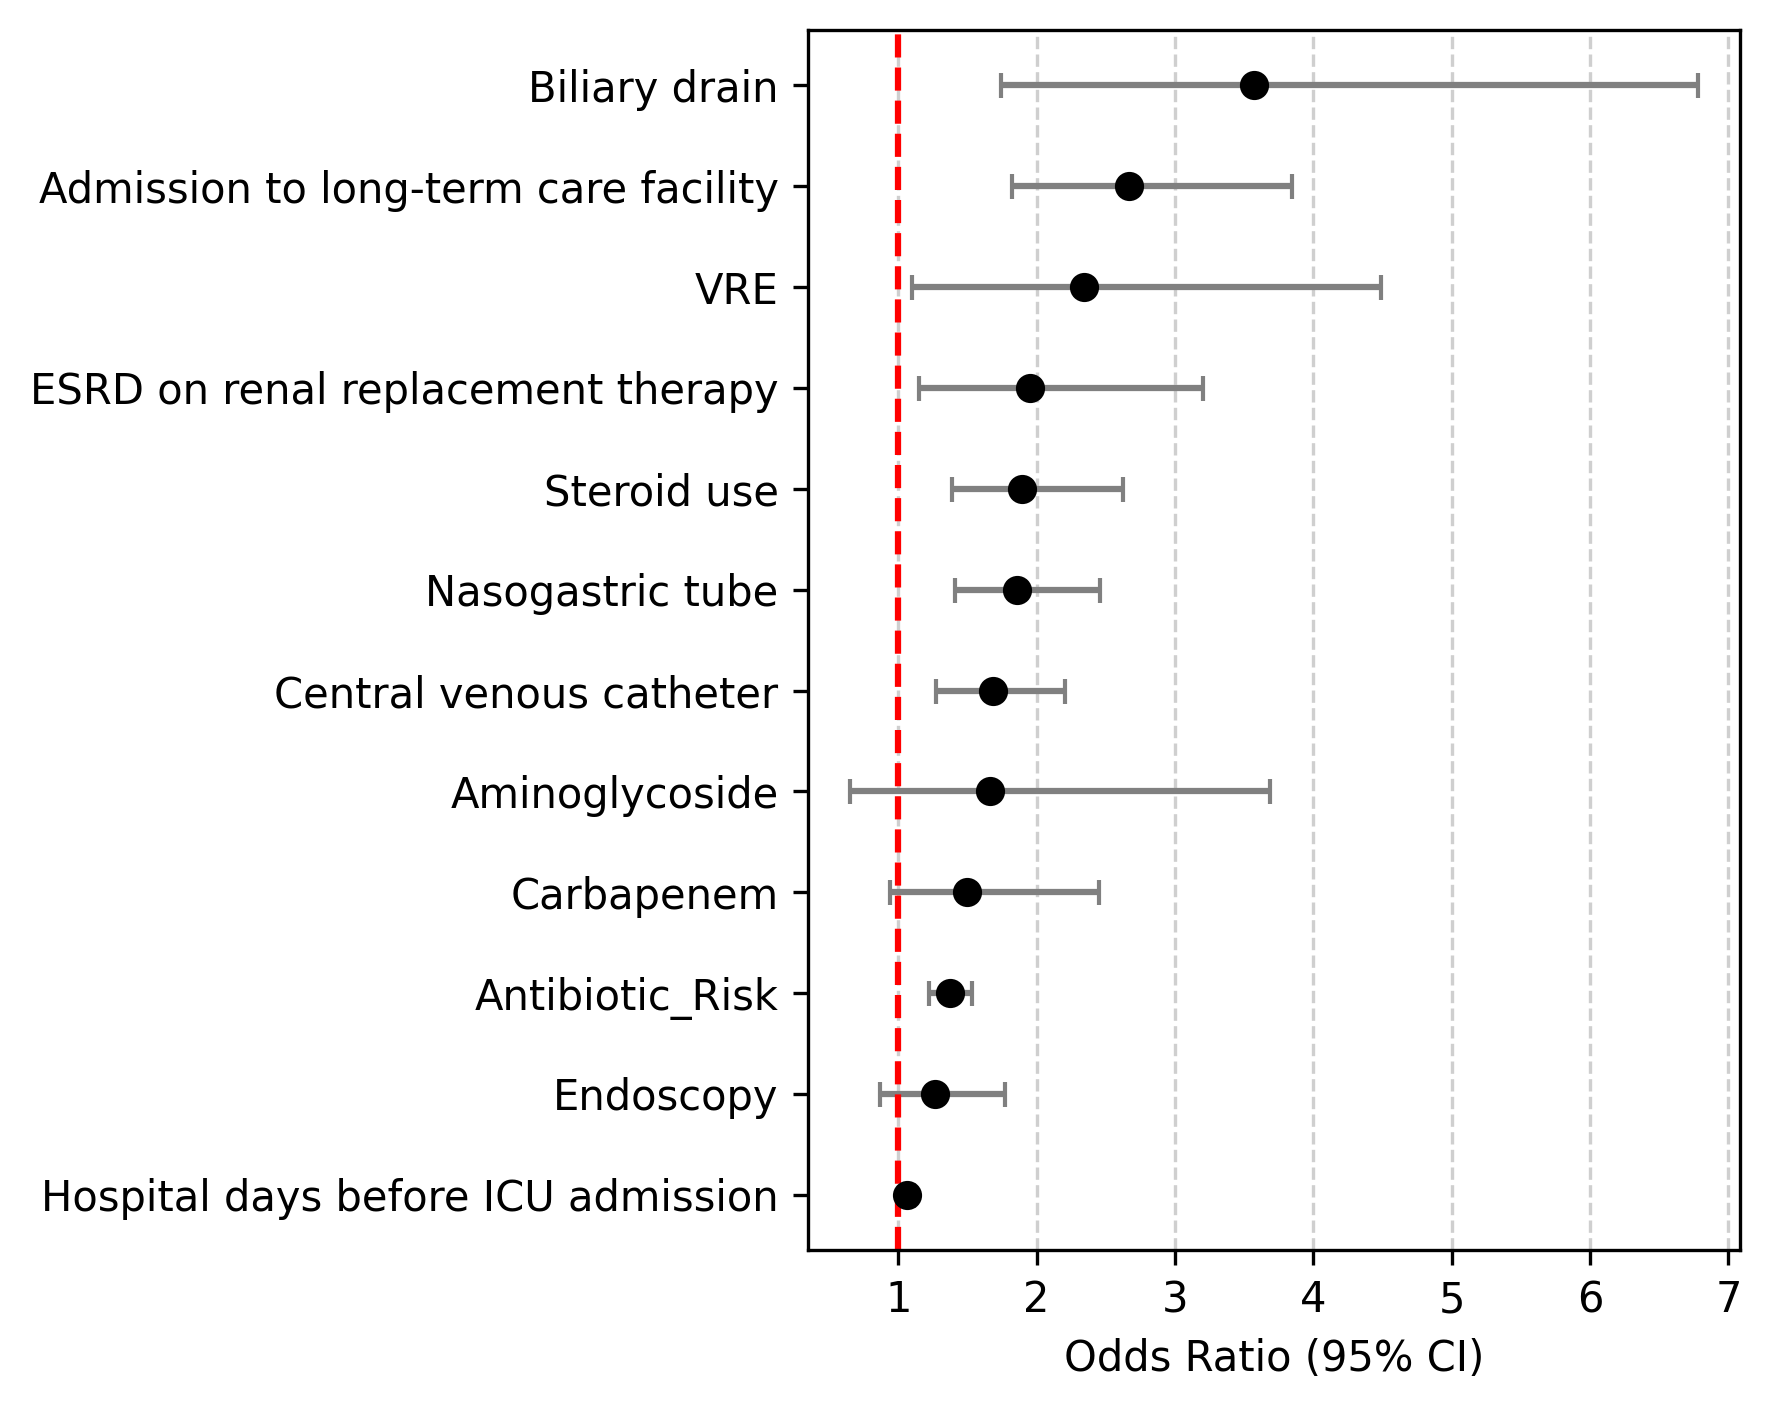

In [20]:
# Fit final model
final_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
final_model.fit(X_train_final, y_train)

# Bootstrap for OR and CI
n_bootstrap = 1000
coefs = []

for _ in range(n_bootstrap):
    X_bs, y_bs = resample(X_train_final, y_train, replace=True)
    model_bs = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    model_bs.fit(X_bs, y_bs)
    coefs.append(model_bs.coef_[0])

coefs = np.array(coefs)
coef_means = final_model.coef_[0]
or_values = np.exp(coef_means)
ci_lower = np.exp(np.percentile(coefs, 2.5, axis=0))
ci_upper = np.exp(np.percentile(coefs, 97.5, axis=0))

or_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'OR': or_values,
    'CI Lower': ci_lower,
    'CI Upper': ci_upper
}).sort_values(by='OR')

# Plot
plt.figure(figsize=(6, 0.4 * len(or_df)), dpi=300)
plt.errorbar(
    or_df['OR'], or_df['Feature'],
    xerr=[or_df['OR'] - or_df['CI Lower'], or_df['CI Upper'] - or_df['OR']],
    fmt='o', color='black', ecolor='gray', capsize=3
)
plt.axvline(x=1, color='red', linestyle='--')
plt.xlabel('Odds Ratio (95% CI)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

buf = io.BytesIO()
plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
buf.seek(0)
Image.open(buf).save("figure1_logistic_or_bootstrap.png")
files.download("figure1_logistic_or_bootstrap.png")

# Sanity check
test_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
test_model.fit(X_train_final, y_train)

corr = np.corrcoef(final_model.coef_[0], test_model.coef_[0])[0, 1]
diff = np.max(np.abs(final_model.coef_[0] - test_model.coef_[0]))

print("\n=== Coefficient Comparison ===")
print(f"Pearson correlation: {corr:.4f}")
print(f"Max absolute difference: {diff:.4f}")

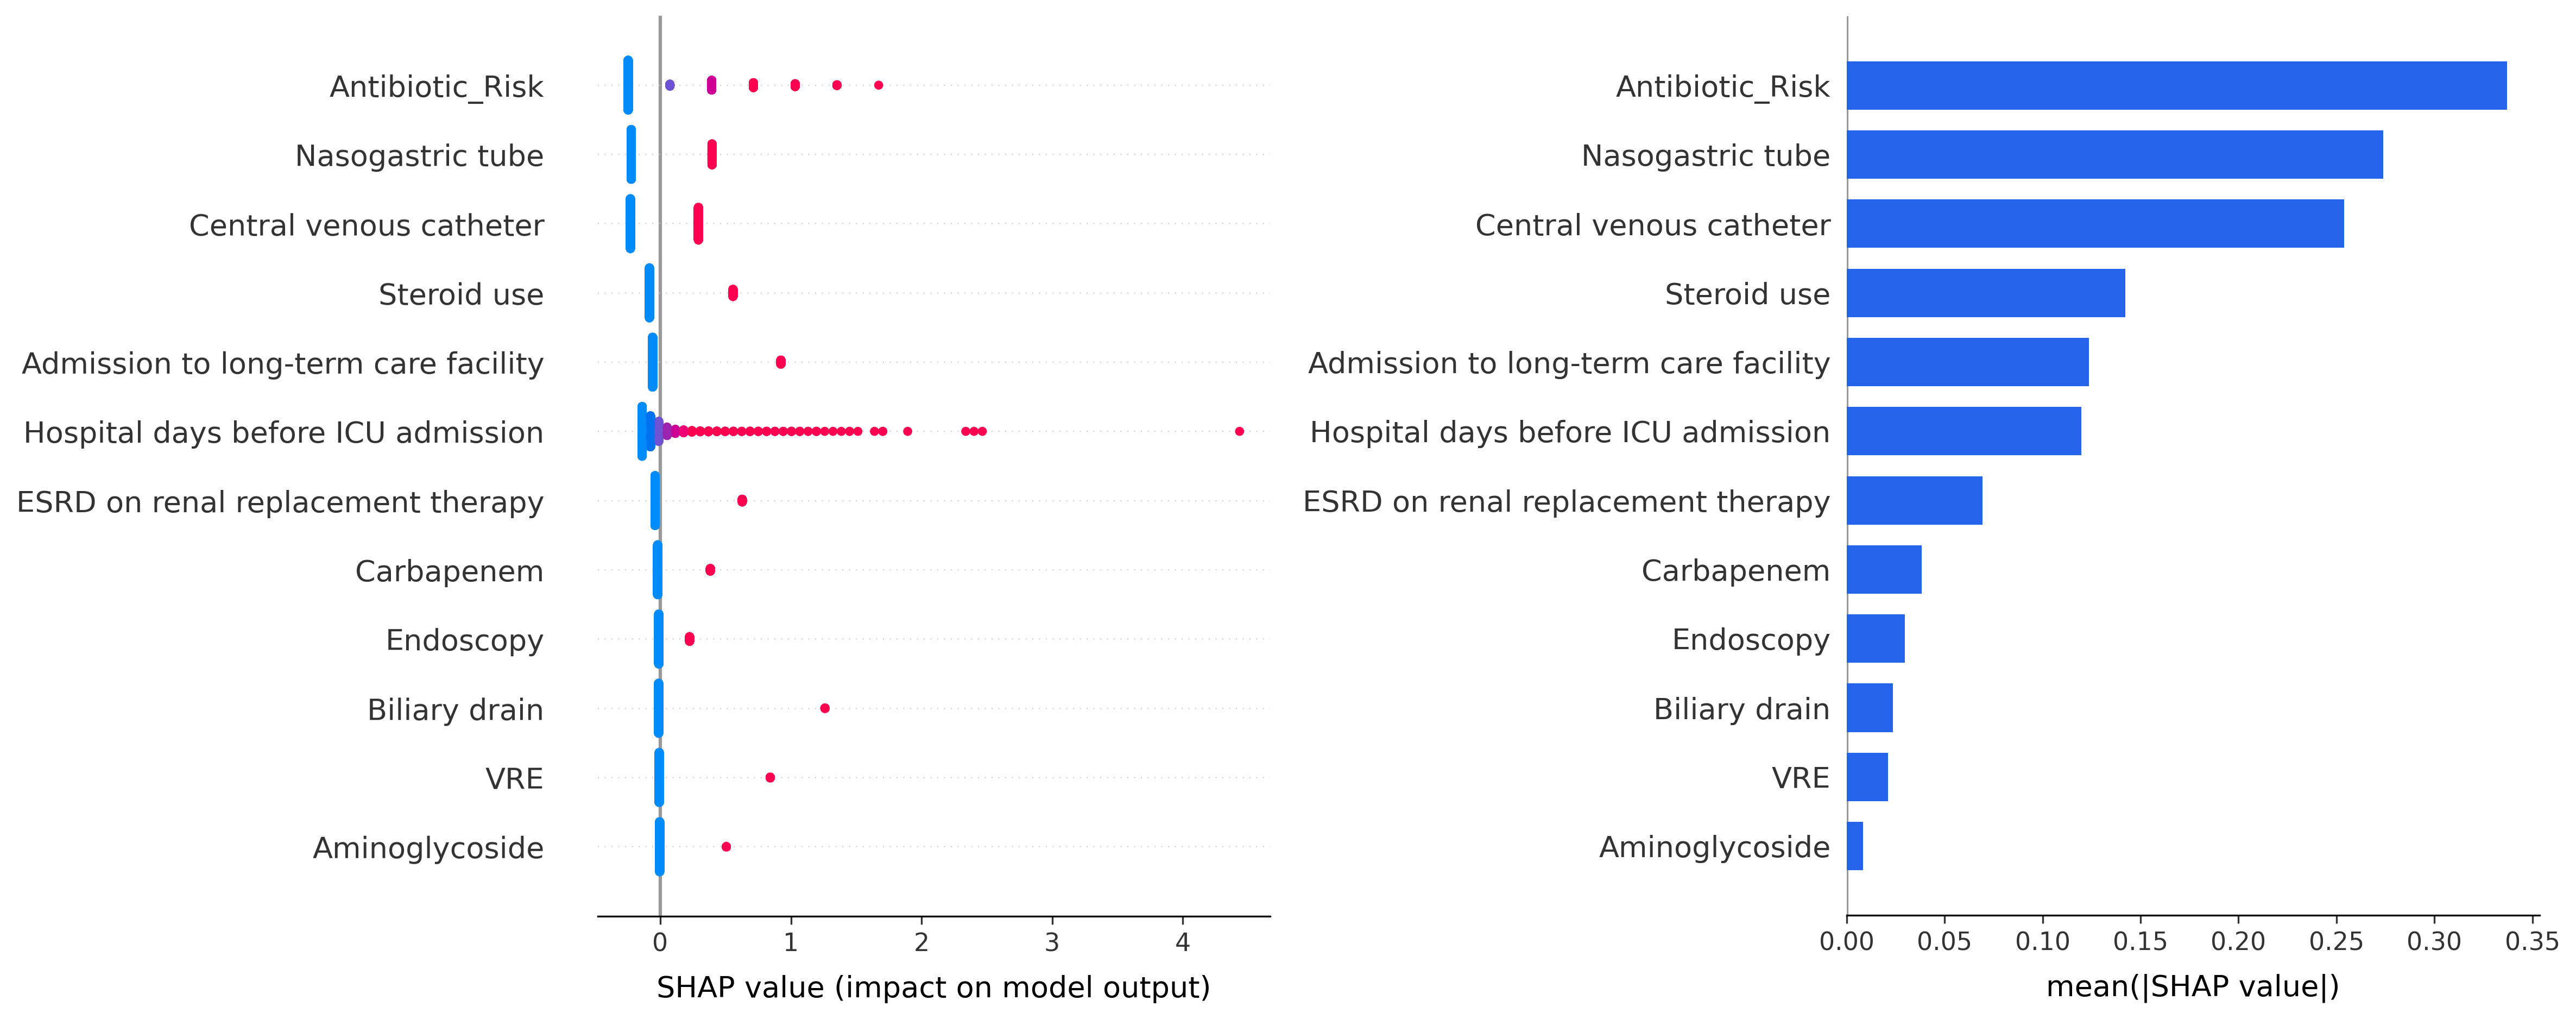

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# Use KernelExplainer for consistency across environments (no GPU)
explainer = shap.Explainer(final_model, X_train_final)
shap_values = explainer(X_train_final)

# === [3] Create SHAP dot plot ===
plt.figure(figsize=(6, 4))
shap.summary_plot(
    shap_values,
    X_train_final,
    plot_type="dot",
    max_display=42,
    show=False,
    color_bar=False  # Remove color bar
)
plt.xlabel("SHAP value (impact on model output)", labelpad=8)
fig_dot = plt.gcf()
plt.close(fig_dot)

buf_dot = io.BytesIO()
fig_dot.savefig(buf_dot, format='png', dpi=300, bbox_inches='tight')
buf_dot.seek(0)
img_dot = Image.open(buf_dot)

# === [4] Create SHAP bar plot with consistent style ===
plt.figure(figsize=(6, 4))
shap.summary_plot(
    shap_values,
    X_train_final,
    plot_type="bar",
    max_display=42,
    show=False,
    color="#2563EB"  # Tailwind Blue
)
plt.xlabel("mean(|SHAP value|)", labelpad=8)
fig_bar = plt.gcf()
plt.close(fig_bar)

buf_bar = io.BytesIO()
fig_bar.savefig(buf_bar, format='png', dpi=300, bbox_inches='tight')
buf_bar.seek(0)
img_bar = Image.open(buf_bar)

# === [5] Align Y axes: equal height for both plots ===
target_height = max(img_dot.height, img_bar.height)
img_dot_resized = img_dot.resize((img_dot.width, target_height))
img_bar_resized = img_bar.resize((img_bar.width, target_height))

# === [6] Combine side-by-side ===
combined_img = Image.new('RGB', (img_dot_resized.width + img_bar_resized.width, target_height), (255, 255, 255))
combined_img.paste(img_dot_resized, (0, 0))
combined_img.paste(img_bar_resized, (img_dot_resized.width, 0))

# === [7] Save and download ===
filename = "figure2_shap_combined.png"
combined_img.save(filename)
display(combined_img)
files.download(filename)

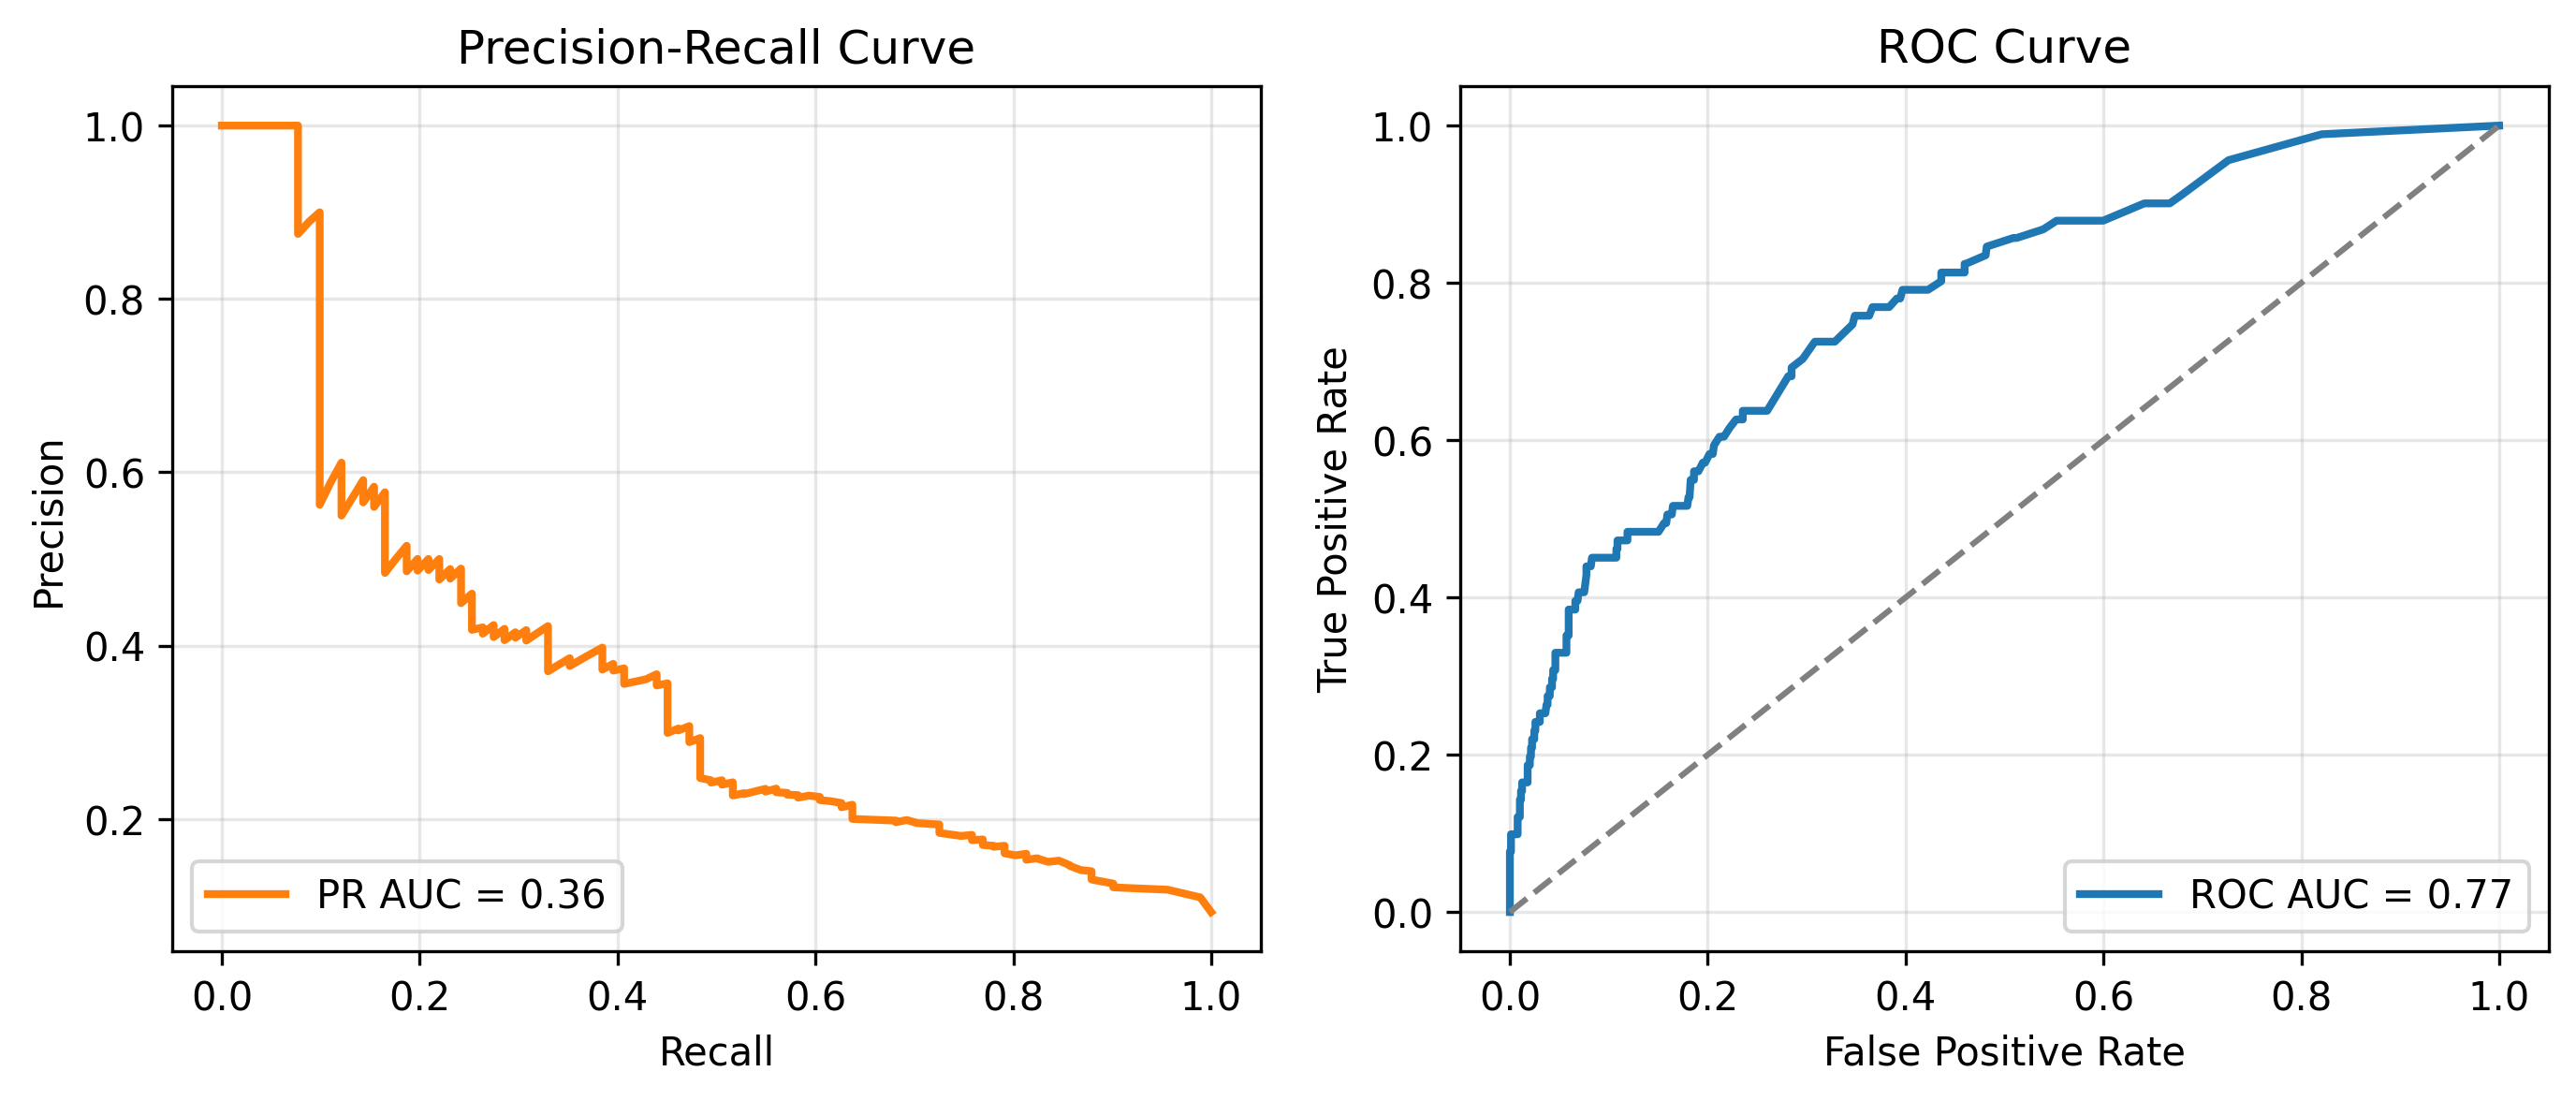

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# Predict probabilities
y_test_proba = final_model.predict_proba(X_test_final)[:, 1]

# Compute metrics
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc = auc(recall, precision)

roc_auc_text = f"ROC AUC = {roc_auc:.2f}"
pr_auc_text = f"PR AUC = {pr_auc:.2f}"

# PR plot (left)
plt.figure(figsize=(5, 4))
plt.plot(recall, precision, color='#ff7f0e', lw=2, label=pr_auc_text)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
fig_pr = plt.gcf()
plt.close()

buf_pr = io.BytesIO()
fig_pr.savefig(buf_pr, format='png', dpi=300, bbox_inches='tight')
buf_pr.seek(0)
img_pr = Image.open(buf_pr)

# ROC plot (right)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='#1f77b4', lw=2, label=roc_auc_text)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
fig_roc = plt.gcf()
plt.close()

buf_roc = io.BytesIO()
fig_roc.savefig(buf_roc, format='png', dpi=300, bbox_inches='tight')
buf_roc.seek(0)
img_roc = Image.open(buf_roc)

# Combine PR (left) + ROC (right)
total_width = img_pr.width + img_roc.width
total_height = max(img_pr.height, img_roc.height)
combined_img = Image.new("RGB", (total_width, total_height), color=(255, 255, 255))
combined_img.paste(img_pr, (0, 0))
combined_img.paste(img_roc, (img_pr.width, 0))

display(combined_img)
filename = "figure2_roc_pr_combined.png"
combined_img.save(filename)
files.download(filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

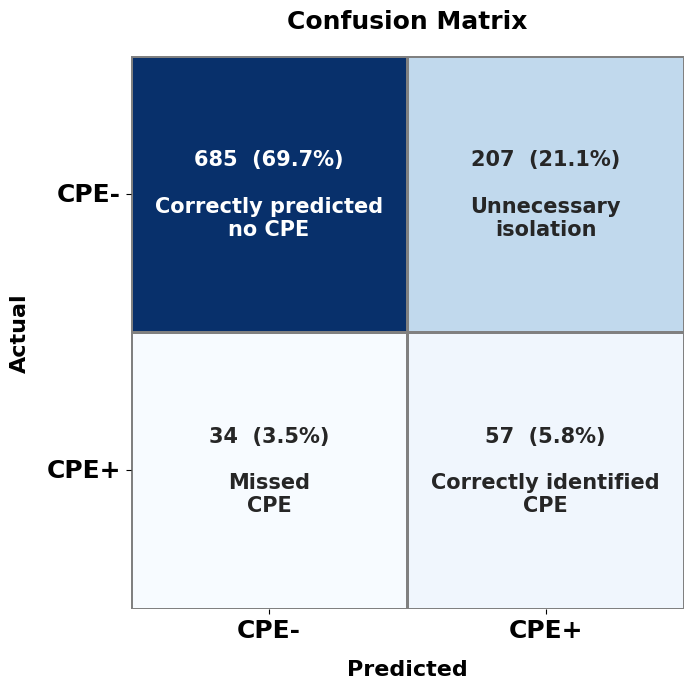

In [27]:
# Example confusion matrix values (replace with actual results)
tn, fp, fn, tp = 685, 207, 34, 57
cm = np.array([[tn, fp], [fn, tp]])
total = cm.sum()
cm_percent = cm / total * 100

# Create labels: count + percent + interpretation
labels = [
    f"{tn:,}  ({cm_percent[0,0]:.1f}%)\n\nCorrectly predicted\nno CPE",
    f"{fp:,}  ({cm_percent[0,1]:.1f}%)\n\nUnnecessary\nisolation",
    f"{fn:,}  ({cm_percent[1,0]:.1f}%)\n\nMissed\nCPE",
    f"{tp:,}  ({cm_percent[1,1]:.1f}%)\n\nCorrectly identified\nCPE"
]
labels = np.array(labels).reshape(2, 2)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, square=True,
            annot_kws={"size": 15, "weight": "bold"}, linewidths=2, linecolor='gray')

ax.set_xlabel("Predicted", fontsize=16, weight='bold', labelpad=12)
ax.set_ylabel("Actual", fontsize=16, weight='bold', labelpad=12)
ax.set_xticklabels(['CPE-', 'CPE+'], fontsize=18, weight='bold')
ax.set_yticklabels(['CPE-', 'CPE+'], fontsize=18, weight='bold', rotation=0)
ax.set_title("Confusion Matrix", fontsize=18, weight='bold', pad=20)
plt.tight_layout()

# Save and download
buf = io.BytesIO()
fig.savefig(buf, format='png', dpi=300, bbox_inches='tight')
buf.seek(0)
img = Image.open(buf)
img.save("confusion_matrix_final.png")
files.download("confusion_matrix_final.png")


#9. Model saving

In [30]:
print("Model saving & Streamlit app development")

import pickle
import joblib

# Save the final model and components
model_components = {
    'model': final_model,
    'features': final_features,
    'threshold': 0.45,
    'scaler': None,  # We don't need scaler for this model
    'model_info': {
         'algorithm': 'Logistic Regression',
         'threshold': 0.45,
         'roc_auc': 0.774,
         'pr_auc': 0.358,                       # Precision-Recall AUC
         'sensitivity': 0.725,
         'specificity': 0.689,
         'ppv': 0.192,                          # Positive Predictive Value
         'npv': 0.961,                          # Negative Predictive Value
         'f1_score': 0.304,
        ' accuracy': 0.693,
         'date_trained': '2025-08-01',
         'train_sample_size': len(X_train_final),
         'test_sample_size': len(X_test_final),
         'institution': 'Hallym University Sacred Heart Hospital'
    }
}

# Save to pickle file
with open('cpe_model.pkl', 'wb') as f:
    pickle.dump(model_components, f)

print("Model saved as 'cpe_model.pkl'")
print(f"Final features: {final_features}")

Model saving & Streamlit app development
Model saved as 'cpe_model.pkl'
Final features: ['Hospital days before ICU admission', 'ESRD on renal replacement therapy', 'Steroid use', 'Central venous catheter', 'Nasogastric tube', 'Biliary drain', 'Carbapenem', 'Aminoglycoside', 'Admission to long-term care facility', 'VRE', 'Endoscopy', 'Antibiotic_Risk']
